## **EN3150 Assignment 03:**
### **Simple convolutional neural network to perform classification.**

In [1]:
# Import necessary Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from torchvision.models import ResNet18_Weights
from torchvision.models import VGG16_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data preparation
data_dir = r"C:\Users\ADMIN\Desktop\Mora\Image Dataset\realwaste-main\RealWaste"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split Dataset
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [4]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * (224 // 8) * (224 // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [5]:
# Training and evaluation functions
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience, patience_counter = 5, 0

    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=3)

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(model(inputs), 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_loss += criterion(model(inputs), labels).item() * inputs.size(0)
                _, preds = torch.max(model(inputs), 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]

        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | LRs: {current_lrs}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    print("Training complete.")
    return train_losses, val_losses

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    return acc, prec, rec, f1, cm, cr


===== Training with Adam =====
Epoch [1/20]  Train Loss: 60.9276 | Val Loss: 42.4663 | Train Acc: 33.01% | Val Acc: 48.88% | LRs: [0.001]
Epoch [2/20]  Train Loss: 42.9824 | Val Loss: 39.1983 | Train Acc: 51.17% | Val Acc: 52.53% | LRs: [0.001]
Epoch [3/20]  Train Loss: 36.7207 | Val Loss: 31.5127 | Train Acc: 59.26% | Val Acc: 61.52% | LRs: [0.001]
Epoch [4/20]  Train Loss: 32.1812 | Val Loss: 31.0058 | Train Acc: 64.40% | Val Acc: 63.76% | LRs: [0.001]
Epoch [5/20]  Train Loss: 28.7550 | Val Loss: 25.6969 | Train Acc: 66.57% | Val Acc: 68.26% | LRs: [0.001]
Epoch [6/20]  Train Loss: 25.1607 | Val Loss: 28.3651 | Train Acc: 71.26% | Val Acc: 65.03% | LRs: [0.001]
Epoch [7/20]  Train Loss: 22.4386 | Val Loss: 24.8382 | Train Acc: 74.80% | Val Acc: 69.80% | LRs: [0.001]
Epoch [8/20]  Train Loss: 19.0024 | Val Loss: 28.2821 | Train Acc: 77.75% | Val Acc: 68.96% | LRs: [0.001]
Epoch [9/20]  Train Loss: 16.7514 | Val Loss: 26.2915 | Train Acc: 81.30% | Val Acc: 69.80% | LRs: [0.001]
Epoch

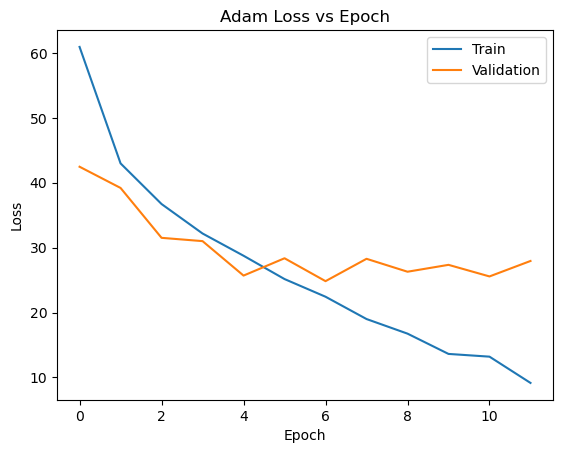


===== Training with SGD =====
Epoch [1/20]  Train Loss: 67.4846 | Val Loss: 60.0491 | Train Acc: 25.47% | Val Acc: 36.10% | LRs: [0.01]
Epoch [2/20]  Train Loss: 59.6550 | Val Loss: 52.3422 | Train Acc: 39.60% | Val Acc: 37.64% | LRs: [0.01]
Epoch [3/20]  Train Loss: 53.2654 | Val Loss: 43.7237 | Train Acc: 45.88% | Val Acc: 49.44% | LRs: [0.01]
Epoch [4/20]  Train Loss: 48.7951 | Val Loss: 43.0715 | Train Acc: 50.96% | Val Acc: 51.54% | LRs: [0.01]
Epoch [5/20]  Train Loss: 45.5928 | Val Loss: 39.1582 | Train Acc: 54.93% | Val Acc: 53.65% | LRs: [0.01]
Epoch [6/20]  Train Loss: 42.8054 | Val Loss: 39.4535 | Train Acc: 58.18% | Val Acc: 53.09% | LRs: [0.01]
Epoch [7/20]  Train Loss: 40.8799 | Val Loss: 35.7568 | Train Acc: 59.11% | Val Acc: 58.85% | LRs: [0.01]
Epoch [8/20]  Train Loss: 38.1632 | Val Loss: 34.6792 | Train Acc: 63.53% | Val Acc: 57.72% | LRs: [0.01]
Epoch [9/20]  Train Loss: 36.8442 | Val Loss: 33.7194 | Train Acc: 65.24% | Val Acc: 57.72% | LRs: [0.01]
Epoch [10/20]  

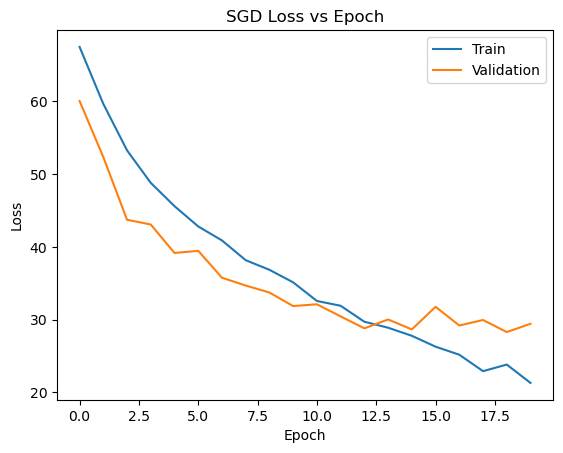


===== Training with SGD+Momentum =====
Epoch [1/20]  Train Loss: 62.7954 | Val Loss: 49.1401 | Train Acc: 27.63% | Val Acc: 37.64% | LRs: [0.01]
Epoch [2/20]  Train Loss: 57.5497 | Val Loss: 47.3203 | Train Acc: 35.87% | Val Acc: 47.61% | LRs: [0.01]
Epoch [3/20]  Train Loss: 51.4155 | Val Loss: 43.7244 | Train Acc: 41.85% | Val Acc: 50.00% | LRs: [0.01]
Epoch [4/20]  Train Loss: 48.1403 | Val Loss: 43.8791 | Train Acc: 48.41% | Val Acc: 49.30% | LRs: [0.01]
Epoch [5/20]  Train Loss: 44.2711 | Val Loss: 40.8303 | Train Acc: 52.13% | Val Acc: 47.33% | LRs: [0.01]
Epoch [6/20]  Train Loss: 37.8115 | Val Loss: 39.2846 | Train Acc: 58.09% | Val Acc: 53.09% | LRs: [0.01]
Epoch [7/20]  Train Loss: 33.8471 | Val Loss: 33.3976 | Train Acc: 65.06% | Val Acc: 60.53% | LRs: [0.01]
Epoch [8/20]  Train Loss: 29.0540 | Val Loss: 35.1899 | Train Acc: 69.69% | Val Acc: 57.58% | LRs: [0.01]
Epoch [9/20]  Train Loss: 25.8869 | Val Loss: 33.7186 | Train Acc: 72.64% | Val Acc: 63.20% | LRs: [0.01]
Epoch 

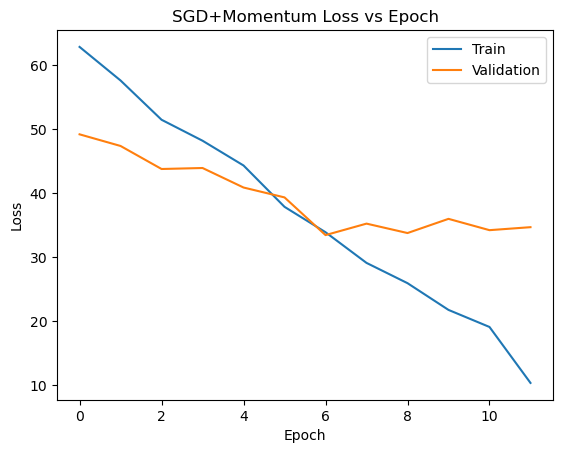

In [ ]:
# Train the model with optimizers Adam, SGD and SGD with momentum
counts = Counter(full_dataset.targets)  
total = sum(counts.values())
class_weights = [total / counts[c] for c in range(len(counts))]

weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizers = {
    "Adam": lambda params: optim.Adam(params, lr=0.001),
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "SGD+Momentum": lambda params: optim.SGD(params, lr=0.01, momentum=0.9)
}

results = {}
for name, opt_fn in optimizers.items():
    print(f"Training with {name}")
    model = SimpleCNN().to(device)
    optimizer = opt_fn(model.parameters())
    train_losses, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20)
    acc, prec, rec, f1, cm, cr = evaluate_model(model, test_loader)
    results[name] = (acc, prec, rec, f1, cm, cr)
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f'{name} Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Adam Results:
Accuracy: 72.83% | Precision: 0.749 | Recall: 0.735 | F1 Score: 0.737
Per-class Performance
                     precision    recall  f1-score   support

          Cardboard       0.71      0.70      0.70        56
      Food Organics       0.85      0.85      0.85        60
              Glass       0.88      0.67      0.76        67
              Metal       0.63      0.78      0.69       116
Miscellaneous Trash       0.73      0.59      0.65        93
              Paper       0.83      0.75      0.79        76
            Plastic       0.69      0.68      0.68       127
      Textile Trash       0.52      0.70      0.60        50
         Vegetation       0.90      0.90      0.90        69

           accuracy                           0.73       714
          macro avg       0.75      0.73      0.74       714
       weighted avg       0.74      0.73      0.73       714



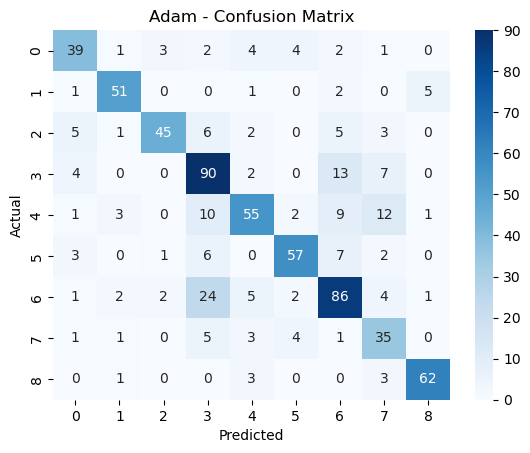


SGD Results:
Accuracy: 63.87% | Precision: 0.682 | Recall: 0.643 | F1 Score: 0.650
Per-class Performance
                     precision    recall  f1-score   support

          Cardboard       0.68      0.61      0.64        56
      Food Organics       0.89      0.80      0.84        60
              Glass       0.77      0.76      0.77        67
              Metal       0.47      0.83      0.60       116
Miscellaneous Trash       0.59      0.43      0.50        93
              Paper       0.74      0.55      0.63        76
            Plastic       0.76      0.52      0.62       127
      Textile Trash       0.42      0.52      0.46        50
         Vegetation       0.83      0.77      0.80        69

           accuracy                           0.64       714
          macro avg       0.68      0.64      0.65       714
       weighted avg       0.68      0.64      0.64       714



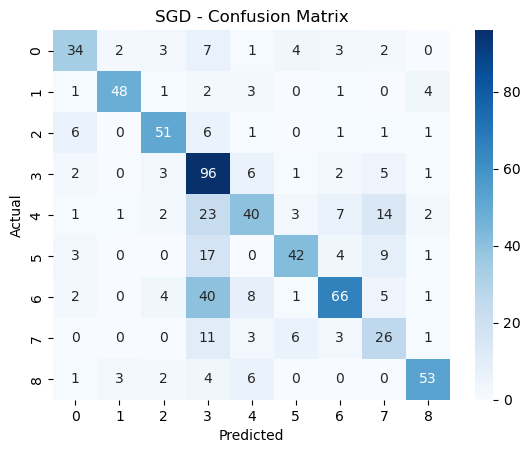


SGD+Momentum Results:
Accuracy: 65.69% | Precision: 0.664 | Recall: 0.654 | F1 Score: 0.655
Per-class Performance
                     precision    recall  f1-score   support

          Cardboard       0.59      0.64      0.62        56
      Food Organics       0.78      0.70      0.74        60
              Glass       0.81      0.64      0.72        67
              Metal       0.60      0.72      0.66       116
Miscellaneous Trash       0.50      0.53      0.51        93
              Paper       0.71      0.61      0.65        76
            Plastic       0.78      0.65      0.71       127
      Textile Trash       0.45      0.52      0.48        50
         Vegetation       0.75      0.87      0.81        69

           accuracy                           0.66       714
          macro avg       0.66      0.65      0.65       714
       weighted avg       0.67      0.66      0.66       714



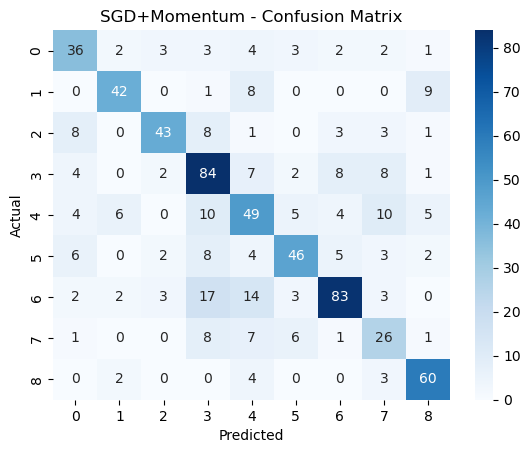

In [ ]:
for name, (acc, prec, rec, f1, cm, cr) in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc*100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1 Score: {f1:.3f}")
    print("Per-class Performance")
    print(cr)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()


===== Fine-tuning ResNet18 =====
Epoch [1/15]  Train Loss: 26.9094 | Val Loss: 16.4094 | Train Acc: 75.83% | Val Acc: 78.93% | LRs: [0.0001, 0.001]
Epoch [2/15]  Train Loss: 6.6894 | Val Loss: 13.1459 | Train Acc: 95.43% | Val Acc: 83.71% | LRs: [0.0001, 0.001]
Epoch [3/15]  Train Loss: 1.7854 | Val Loss: 12.4310 | Train Acc: 99.70% | Val Acc: 85.96% | LRs: [0.0001, 0.001]
Epoch [4/15]  Train Loss: 0.6267 | Val Loss: 12.6240 | Train Acc: 100.00% | Val Acc: 87.36% | LRs: [0.0001, 0.001]
Epoch [5/15]  Train Loss: 0.2661 | Val Loss: 12.9333 | Train Acc: 100.00% | Val Acc: 86.80% | LRs: [0.0001, 0.001]
Epoch [6/15]  Train Loss: 0.2640 | Val Loss: 11.5914 | Train Acc: 100.00% | Val Acc: 88.06% | LRs: [0.0001, 0.001]
Epoch [7/15]  Train Loss: 0.2157 | Val Loss: 12.3410 | Train Acc: 100.00% | Val Acc: 87.08% | LRs: [0.0001, 0.001]
Epoch [8/15]  Train Loss: 0.1808 | Val Loss: 13.6672 | Train Acc: 100.00% | Val Acc: 87.36% | LRs: [0.0001, 0.001]
Epoch [9/15]  Train Loss: 0.0808 | Val Loss: 13.

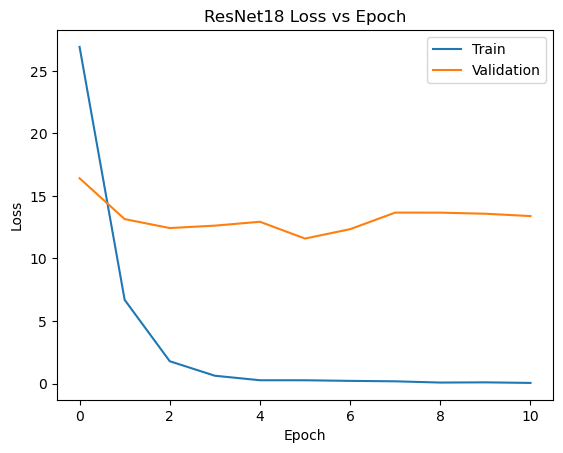

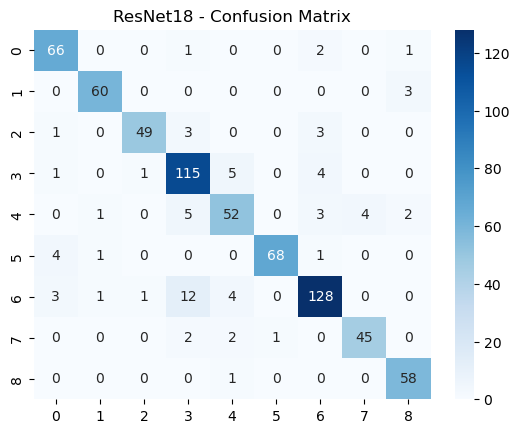

Per-class performance:
                     precision    recall  f1-score   support

          Cardboard       0.88      0.94      0.91        70
      Food Organics       0.95      0.95      0.95        63
              Glass       0.96      0.88      0.92        56
              Metal       0.83      0.91      0.87       126
Miscellaneous Trash       0.81      0.78      0.79        67
              Paper       0.99      0.92      0.95        74
            Plastic       0.91      0.86      0.88       149
      Textile Trash       0.92      0.90      0.91        50
         Vegetation       0.91      0.98      0.94        59

           accuracy                           0.90       714
          macro avg       0.91      0.90      0.90       714
       weighted avg       0.90      0.90      0.90       714


===== Fine-tuning VGG16 =====
Epoch [1/15]  Train Loss: 40.7739 | Val Loss: 23.9968 | Train Acc: 53.55% | Val Acc: 71.91% | LRs: [0.0001]
Epoch [2/15]  Train Loss: 20.1317 | Val Lo

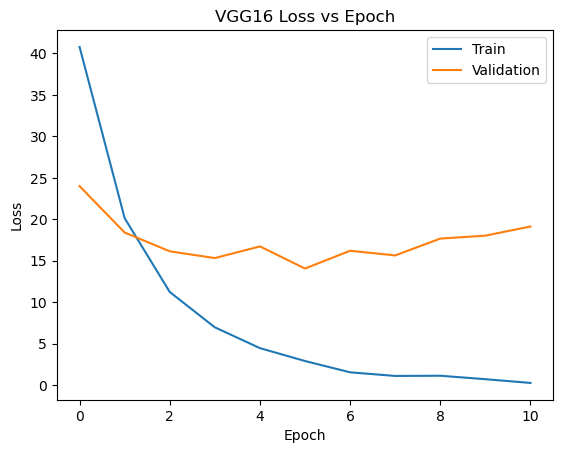

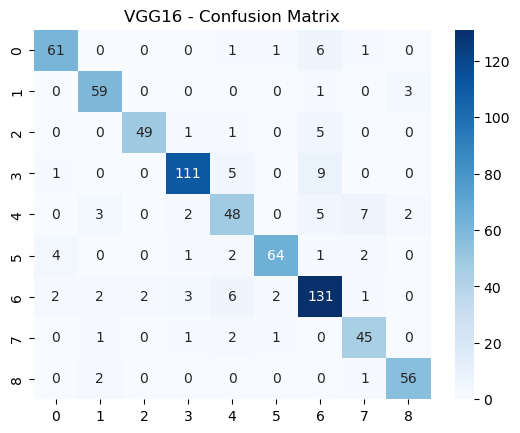

Per-class performance:
                     precision    recall  f1-score   support

          Cardboard       0.90      0.87      0.88        70
      Food Organics       0.88      0.94      0.91        63
              Glass       0.96      0.88      0.92        56
              Metal       0.93      0.88      0.91       126
Miscellaneous Trash       0.74      0.72      0.73        67
              Paper       0.94      0.86      0.90        74
            Plastic       0.83      0.88      0.85       149
      Textile Trash       0.79      0.90      0.84        50
         Vegetation       0.92      0.95      0.93        59

           accuracy                           0.87       714
          macro avg       0.88      0.87      0.87       714
       weighted avg       0.88      0.87      0.87       714



In [ ]:
# Transfer learning using ResNet18
print("\n===== Fine-tuning ResNet18 =====")
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))
resnet = resnet.to(device)

# Use discriminative learning rates
optimizer_ft = optim.Adam([
    {'params': resnet.layer4.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': resnet.fc.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4}
])


train_losses, val_losses = train_model(resnet, optimizer_ft, criterion, train_loader, val_loader, epochs=15)
acc_ft, prec_ft, rec_ft, f1_ft, cm_ft, cr_ft = evaluate_model(resnet, test_loader)
print(f"Accuracy: {acc_ft*100:.2f}% | Precision: {prec_ft:.3f} | Recall: {rec_ft:.3f} | F1-Score:  {f1_ft:.3f}")

# Plot Loss Curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('ResNet18 Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet18 - Confusion Matrix')
plt.show()

print("Per-class performance:")
print(cr_ft)

# Transfer Learning using VGG16
print("Fine-tuning VGG16")
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in vgg16.parameters():
    param.requires_grad = False
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))

for name, param in vgg16.classifier.named_parameters():
    if "6" in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in vgg16.features[24:].named_parameters():
    param.requires_grad = True

vgg16 = vgg16.to(device)

optimizer_ft = optim.Adam(
    list(vgg16.features[24:].parameters()) + list(vgg16.classifier[6].parameters()),
    lr=1e-4,
    weight_decay=1e-4
)


train_losses, val_losses = train_model(vgg16, optimizer_ft, criterion, train_loader, val_loader, epochs=15)
acc_vgg, prec_vgg, rec_vgg, f1_vgg, cm_vgg, cr_vgg = evaluate_model(vgg16, test_loader)
print(f"VGG16 Fine-tuned Accuracy: {acc_vgg*100:.2f}% | Precision: {prec_vgg:.3f} | Recall: {rec_vgg:.3f} | F1-Score:  {f1_vgg:.3f}")

# Plot Loss Curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('VGG16 Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues')
plt.title('VGG16 - Confusion Matrix')
plt.show()

print("Per-class performance:")
print(cr_vgg)